## Full Spectrum (widest) Combined
### from New Data/Spectrum blocked (widest)/A0036 and New Data/Spectrum (widest)/A0035

In [38]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [39]:
# Calibration numbers come from multiple calibrations with proper error analysis and weighted averaging
# Calulations can be found in "Multiple Plot Calibration"
CalM = -5.169066740202884
CalM_err = 1.8472146461547026e-06

# define functions
def LinearFunc(t, a, b):
    return a * t + b

def ChiSqrd(Data, Fit, Error):
    return sum( (Data - Fit)**2 ) / (Error**2)

def RdChiSqrd(Data, Fit, Error, NumPrams):
    return sum( (Data - Fit)**2 ) / (Error**2 * (np.size(Data) - NumPrams - 2))

def Cali(t, t0, DriveSlope):
    return (10 * DriveSlope * CalM * (t - t0))

def Cali_Err(t, t0, t0_err, DriveSlope, DriveSlope_err):
    return np.sqrt( (10 * DriveSlope_err * CalM * (t - t0))**2 +
                    (10 * DriveSlope * CalM_err * (t - t0))**2 +
                    (10 * DriveSlope * CalM * t0_err)**2 )

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, (len(params)-2), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( (-1/2) * ((x - ctr)/wid)**2)
    return y + x * params[12] + params[13]

36.296814456069576
0.023327224386140384


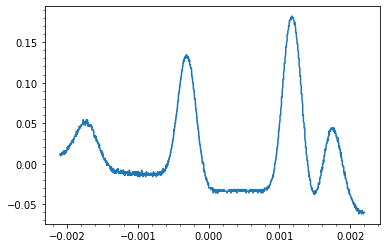

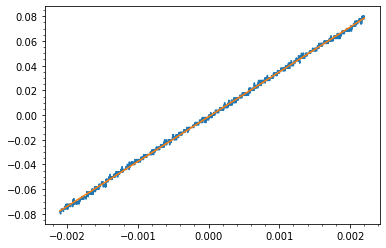

In [40]:
data =  pd.read_csv("New Data/Spectrum blocked (widest)/A0036CH1.CSV")
x = pd.DataFrame(data, columns= ['col 1'])
y = pd.DataFrame(data, columns= ['col 2'])
x = np.resize(x,(4000,1))
y = np.resize(y,(4000,1))

rampdata =  pd.read_csv("New Data/Spectrum blocked (widest)/A0036CH2.CSV")
rampx = pd.DataFrame(rampdata, columns= ['col 1'])
rampy = pd.DataFrame(rampdata, columns= ['col 2'])
rampx = np.resize(rampx,(4000,1))
rampy = np.resize(rampy,(4000,1))

#plt.plot(rampx,rampy)

t_start = -0.0021
t_end = 0.0022

j = 0
for i in x:
    if i == t_start:
        t1 = j
    if i == t_end:
        t2 = j
    j += 1

x = x[t1:t2,0]
y = y[t1:t2,0]
rampx = rampx[t1:t2,0]
rampy = rampy[t1:t2,0]

RampGuess = [36, 0.2]
RampParam, RampParam_cov = curve_fit(LinearFunc, rampx, rampy, RampGuess, maxfev=150000)

RampSlope = RampParam[0]
RampSlope_err = RampParam_cov[0,0]
print(RampSlope)
print(np.sqrt(RampParam_cov[0,0]))

plt.plot(x,y)
plt.minorticks_on()
plt.show()
plt.plot(rampx,rampy)
plt.plot(rampx,LinearFunc(rampx,*RampParam))
plt.minorticks_on()
plt.show()

Y-error = (+/-) 0.0015998967505494457
[-2.62716022 -0.01513832]


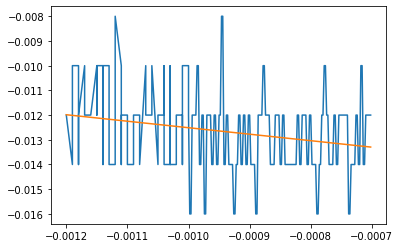

In [41]:
# Finds Error in the voltage

# Find flat '0' segments
# Here I'm taking from t=-0.0001 to t=0.0001
j = 0
for i in x: 
    if i == -0.0012:
        t1 = j
    if i == -0.0007:
        t2 = j
    j += 1
    
x_back = x[t1:t2]
y_back = y[t1:t2]

Back_guess = [-18,-.014]

Back_popt, Back_pcov = optimize.curve_fit(LinearFunc, x_back, y_back, Back_guess, maxfev=150000)

V_error = np.sqrt( sum( (y_back - LinearFunc(x_back, *Back_popt))**2 ) / (np.size(x_back) - 2) )

print("Y-error = (+/-) " + str(V_error))

print(Back_popt)

plt.plot(x_back,y_back)
plt.plot(x_back, LinearFunc(x_back, *Back_popt))
plt.show()

V_errorA = V_error * np.linspace(1,1,np.size(x))
    

87Rb F=1 Peak Position: 0.0017629805698671829 +/- 5.372912992061049e-07
Reduced Chi Squared = 3.764202263548545


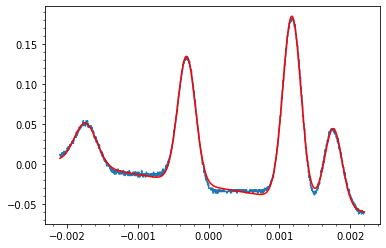

[0.00101391 0.00101388 0.00101388 ... 0.00100814 0.00100814 0.00100814]
Reduced Chi Squared = 3.764202264362494


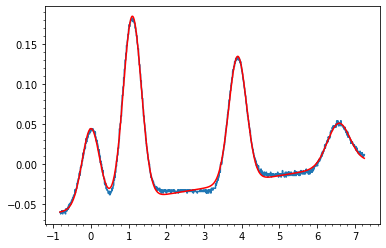

87Rb F=2 Seperation: -1.2823965085849013e-06 +/- 0.0010081332250269155
87Rb F=2 FWHM: -0.5451022035558637 +/- 0.002853311068267344
85Rb F=3 Seperation: 1.0990592614719368 +/- 0.00043350764715886114
85Rb F=3 FWHM: 0.5638437062037565 +/- 0.0011371968441885203
85Rb F=2 Seperation: 3.891437433309482 +/- 0.0006249610800245543
85Rb F=2 FWHM: 0.5541531586598721 +/- 0.001569142689950468
87Rb F=1 Seperation: 6.569714747662758 +/- 0.0021019684680214077
87Rb F=1 FWHM: 0.7046205748759576 +/- 0.006173985267584258


In [25]:
# Fit curve, apply Calibration

guess = [-0.0018, 0.05000, 0.00020, -0.0003, 0.15000, 0.00020, 0.001, 0.21000, 0.00020, 0.0015, 0.05000, 0.00020, -18, -.0138]
# position, amplitude, width

popt, pcov = optimize.curve_fit(func, x, y, p0=guess, sigma= V_errorA, maxfev=200000)
fit = func(x, *popt)

print("87Rb F=1 Peak Position: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
RCS = RdChiSqrd(y, func(x, *popt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(x, y)
plt.plot(x, fit , 'r-')
plt.minorticks_on()
plt.show()

ZeroPos = popt[9]
ZeroPos_err = np.sqrt(pcov[9,9])

# Calibration
Calx = Cali(x, ZeroPos, RampSlope)

#Cali_Err(t, t0, t0_err, DriveSlope, DriveSlope_err)
Calx_err = Cali_Err(x, ZeroPos, ZeroPos_err, RampSlope, RampSlope_err)

print(Calx_err)

#Cguess = [0.0, 0.1, 0.606, 1.1, 0.20, 0.541, 4.0, 0.20, 0.524, 6.518, 0.05, 0.559, 0, -.05]
# position, amplitude, width|              |                 |                   |

#popt, pcov = optimize.curve_fit(func, Calx, y, p0=Cguess, maxfev=150000)
#fit = func(Calx, *popt)
#RCS = RdChiSqrd(y, func(Calx, *popt), V_error, 12)
#print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, y)
#plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

#print("87Rb F=2 Seperation: " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0,0])) )
#print("87Rb F=2 FWHM: " + str(2.35482*popt[2]) + " +/- " + str(2.35482*np.sqrt(pcov[2,2])) )
#print("85Rb F=3 Seperation: " + str(popt[3]) + " +/- " + str(np.sqrt(pcov[3,3])) )
#print("85Rb F=3 FWHM: " + str(2.35482*popt[5]) + " +/- " + str(2.35482*np.sqrt(pcov[5,5])) )
#print("85Rb F=2 Seperation: " + str(popt[6]) + " +/- " + str(np.sqrt(pcov[6,6])) )
#print("85Rb F=2 FWHM: " + str(2.35482*popt[8]) + " +/- " + str(2.35482*np.sqrt(pcov[8,8])) )
#print("87Rb F=1 Seperation: " + str(popt[9]) + " +/- " + str(np.sqrt(pcov[9,9])) )
#print("87Rb F=1 FWHM: " + str(2.35482*popt[11]) + " +/- " + str(2.35482*np.sqrt(pcov[11,11])) )

Reduced Chi Squared = 26.4132631101725


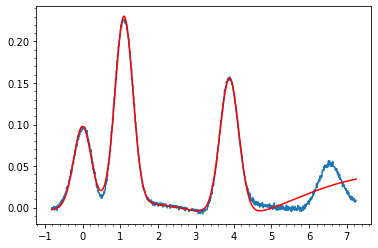

87Rb F=2 Seperation: -0.005269622560119945 +/- 0.0027151142673946874
87Rb F=2 FWHM:       0.5422765685410383 +/- 0.00883130918421382
85Rb F=3 Seperation: 1.0979313830726602 +/- 0.0011792291582534992
85Rb F=3 FWHM:       0.5504911254925706 +/- 0.0031507356900989003
85Rb F=2 Seperation: 3.893097117875746 +/- 0.0016896285518070995
85Rb F=2 FWHM:       0.5895991535422647 +/- 0.005086803538117348
87Rb F=1 Seperation: 4.270441657977176 +/- 0.04056526087930576
87Rb F=1 FWHM:       3.241120839875852 +/- 0.15119917418850953


In [37]:
#Flattens
yFlat = y - LinearFunc(Calx, popt[12], popt[13])

CFlatguess = [0.0, 0.1, -0.606, 1.1, 0.20, 0.541, 4.0, 0.20, 0.524, 6.518, 0.05, -0.559, 0, 0]
# position, amplitude, width

Fpopt, Fpcov = optimize.curve_fit(func, Calx, yFlat, p0=CFlatguess, maxfev=150000)
fit = func(Calx, *Fpopt)
RCS = RdChiSqrd(yFlat, func(Calx, *Fpopt), V_error, 12)
print("Reduced Chi Squared = " + str(RCS))

plt.plot(Calx, yFlat)
plt.plot(Calx, fit , 'r-')
plt.minorticks_on()
plt.show()

print("87Rb F=2 Seperation: " + str(Fpopt[0]) + " +/- " + str(np.sqrt(Fpcov[0,0])) )
print("87Rb F=2 FWHM:       " + str(2.35482*Fpopt[2]) + " +/- " + str(2.35482*np.sqrt(Fpcov[2,2])) )
print("85Rb F=3 Seperation: " + str(Fpopt[3]) + " +/- " + str(np.sqrt(Fpcov[3,3])) )
print("85Rb F=3 FWHM:       " + str(2.35482*Fpopt[5]) + " +/- " + str(2.35482*np.sqrt(Fpcov[5,5])) )
print("85Rb F=2 Seperation: " + str(Fpopt[6]) + " +/- " + str(np.sqrt(Fpcov[6,6])) )
print("85Rb F=2 FWHM:       " + str(2.35482*Fpopt[8]) + " +/- " + str(2.35482*np.sqrt(Fpcov[8,8])) )
print("87Rb F=1 Seperation: " + str(Fpopt[9]) + " +/- " + str(np.sqrt(Fpcov[9,9])) )
print("87Rb F=1 FWHM:       " + str(2.35482*Fpopt[11]) + " +/- " + str(2.35482*np.sqrt(Fpcov[11,11])) )

## Unblocked

36.17791535741955
0.022050483639657142


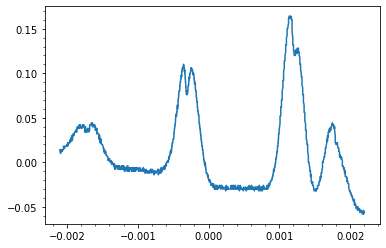

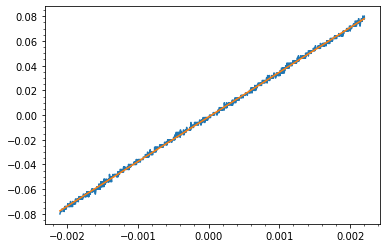

In [40]:
Udata =  pd.read_csv("New Data/Spectrum (widest)/A0035CH1.CSV")
Ux = pd.DataFrame(Udata, columns= ['col 1'])
Uy = pd.DataFrame(Udata, columns= ['col 2'])
Ux = np.resize(Ux,(4000,1))
Uy = np.resize(Uy,(4000,1))

Urampdata =  pd.read_csv("New Data/Spectrum (widest)/A0035CH2.CSV")
Urampx = pd.DataFrame(Urampdata, columns= ['col 1'])
Urampy = pd.DataFrame(Urampdata, columns= ['col 2'])
Urampx = np.resize(Urampx,(4000,1))
Urampy = np.resize(Urampy,(4000,1))

#plt.plot(Urampx,Urampy)

t_start = -0.0021
t_end = 0.0022

j = 0
for i in Ux:
    if i == t_start:
        Ut1 = j
    if i == t_end:
        Ut2 = j
    j += 1

Ux = Ux[Ut1:Ut2,0]
Uy = Uy[Ut1:Ut2,0]
Urampx = Urampx[Ut1:Ut2,0]
Urampy = Urampy[Ut1:Ut2,0]

URampGuess = [36, 0.2]
URampParam, URampParam_cov = curve_fit(LinearFunc, Urampx, Urampy, URampGuess, maxfev=150000)

URampSlope = URampParam[0]
print(URampSlope)
print(np.sqrt(URampParam_cov[0,0]))

plt.plot(Ux,Uy)
plt.minorticks_on()
plt.show()
plt.plot(Urampx,Urampy)
plt.plot(Urampx,LinearFunc(Urampx,*URampParam))
plt.minorticks_on()
plt.show()

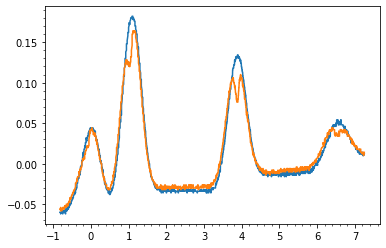

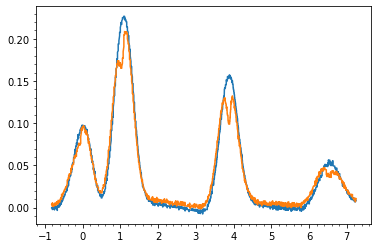

In [44]:
UCalx = Cali(Ux, ZeroPos, RampSlope)
UyFlat = Uy - LinearFunc(UCalx, popt[12], popt[13])

plt.plot(Calx, y)
plt.plot(UCalx, Uy)
plt.minorticks_on()
plt.show()

plt.plot(Calx, yFlat)
plt.plot(UCalx, UyFlat)
plt.minorticks_on()
plt.show()